# DataSci200 Final Project 2  | NFL Offensive Play Exploratory Analysis 2009 - 2017 
Tyler Gustafson's Notebook | Team: Abhishek Shetty, Bikram Khaira, Tyler Gustafson | Fall 2023-Ysis Tarter-Tues
- Section 1: Santity Checking
- Section 2: Initial Exploratory Analysis
- Section 3: Impact of General Factors on Offense

# Section 1: Santity Checking

In [40]:
%matplotlib inline
import sys
print(sys.version)
import numpy as np
print(np.__version__)
import pandas as pd
print(pd.__version__)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

3.11.3 (tags/v3.11.3:f3909b8, Apr  4 2023, 23:49:59) [MSC v.1934 64 bit (AMD64)]
1.25.2
2.0.3


In [41]:
file_path = 'C:/Users/tggus/OneDrive/Desktop/00 UC Berkeley/Data Sci - 200/Project/NFL Play by Play 2009-2017 (v4).csv'
nfl_plays = pd.read_csv(file_path)

C:\Users\tggus\AppData\Local\Temp\ipykernel_8532\4188819084.py:2: DtypeWarning: Columns (25,51) have mixed types. Specify dtype option on import or set low_memory=False.
  nfl_plays = pd.read_csv(file_path)


In [ ]:
#View data types in data frame
nfl_plays.dtypes

In [ ]:
#View original data frame
nfl_plays.head(1)

The following code was used to prepare the data set
- Functions to categorize time periods
- Dropped Columns
- Added Columns for analysis

In [45]:
#Create functions for required added columns
def categorize_time_in_quarter(row):
    """This function takes the time remaining and classifies it into time block groups and used
    for the impact of time on turnovers and penalties.
    """   
    #Calculate the time left in the current quarter (900 seconds in a quarter)
    quarter_time_left = row['TimeSecs'] % 900    
    
    if quarter_time_left > 600 or quarter_time_left == 0:
        return 'Start' 
    elif quarter_time_left > 300:
        return 'Middle'
    else:
        return 'End'
    
#Define bins and labels for the yard line ranges in groups of 10
bins = list(range(0, 101, 10))
labels = [f'{i}-{i+9}' for i in range(0, 100, 10)]

In [46]:
#Dropped columns
columns_to_drop = ['Receiver','Receiver_ID', 'Rusher','Rusher_ID','ReturnResult','Returner','BlockingPlayer','Tackler1','Tackler2','Challenge.Replay','ChalReplayResult',
    'Timeout_Indicator','Timeout_Team','posteam_timeouts_pre','HomeTimeouts_Remaining_Pre',
    'AwayTimeouts_Remaining_Pre','HomeTimeouts_Remaining_Post','AwayTimeouts_Remaining_Post',
    'No_Score_Prob','Opp_Field_Goal_Prob','Opp_Safety_Prob','Opp_Touchdown_Prob','Field_Goal_Prob','Safety_Prob',
    'Touchdown_Prob','ExPoint_Prob','TwoPoint_Prob','ExpPts','EPA','airEPA','yacEPA','Home_WP_pre','Away_WP_pre','Home_WP_post',
    'Away_WP_post','Win_Prob','WPA','airWPA','yacWPA']

updated_nfl_plays  = nfl_plays.drop(columns_to_drop,axis = 1)

#Added columns: Create binary Pass Length, Run Location and Pass Location Binary Columns)
pass_length_dummies = pd.get_dummies(nfl_plays['PassLength'])
run_location_dummies = pd.get_dummies(nfl_plays['RunLocation'],prefix='RunLocation')
pass_location_dummies = pd.get_dummies(nfl_plays['PassLocation'],prefix='PassLocation')
updated_nfl_plays = pd.concat([updated_nfl_plays,pass_length_dummies,run_location_dummies,pass_location_dummies],axis=1)

#Added columms: Calculated for analysis (Total Points, Total Turnovers, Field Goal Good, Penalty Occurred, Penalty Yards and Quarter Time Category)
updated_nfl_plays['TotalPoints'] = updated_nfl_plays['PosTeamScore'] + updated_nfl_plays['DefTeamScore']
updated_nfl_plays['TotalTurnovers'] = updated_nfl_plays['InterceptionThrown'] + updated_nfl_plays['Fumble']
updated_nfl_plays['FieldGoalGood'] = updated_nfl_plays['FieldGoalResult'].apply(lambda x: 1 if x == 'Good' else 0)
updated_nfl_plays['PenaltyOccurred'] = updated_nfl_plays['PenalizedTeam'].apply(lambda x: 0 if pd.isna(x) else 1)
updated_nfl_plays['PenatlyYards'] = updated_nfl_plays['Penalty.Yards'].apply(lambda x: x if x > 0 else np.nan)
updated_nfl_plays['QuarterTimeCategory'] = updated_nfl_plays.apply(categorize_time_in_quarter, axis=1)

#Added column: Create binned 10 yard groupings for analysis
updated_nfl_plays['yrdline_range'] = pd.cut(updated_nfl_plays['yrdline100'], bins=bins, labels=labels, right=False)


updated_nfl_plays.head(2)

,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,...,PassLocation_left,PassLocation_middle,PassLocation_right,TotalPoints,TotalTurnovers,FieldGoalGood,PenaltyOccurred,PenatlyYards,QuarterTimeCategory,yrdline_range
0,2009-09-10,2009091000,1,1,NaN,15:00,15,3600.0,0.0,TEN,...,False,False,False,0.0,0,0,0,NaN,Start,30-39
1,2009-09-10,2009091000,1,1,1.0,14:53,15,3593.0,7.0,PIT,...,True,False,False,0.0,0,0,0,NaN,Start,50-59


# Section 2: Exploratory Analysis

Before jumping into our three key analytical groups on specific offense trends, we wanted to understand in the data how the NFL has evolved on various offensive metrics during the seasons in the dataset. Some of the key metrics we were curious about were Avg Total Points per game, Total Turnovers, Penalties and Touchdowns per game. Here is a table that dives into this data a little bit more.

In [48]:
#Filter out penalty plays for Yards.Gained calculation
filtered_plays_for_yards = updated_nfl_plays[(updated_nfl_plays['PenaltyOccurred'] == 0)]

#Calculate Yards.Gained for the filtered plays
yards_gained = filtered_plays_for_yards.groupby(['Season', 'GameID'])['Yards.Gained'].sum()

#Aggregate other metrics for all plays
games_all = updated_nfl_plays.groupby(['Season', 'GameID']).agg({
    'TotalPoints': 'max', 
    'TotalTurnovers': 'sum',
    'PenaltyOccurred': 'sum',
    #'PenatlyYards': 'sum',
    #'Onsidekick': 'sum',
    'Touchdown': 'sum',
    'FieldGoalGood': 'sum'    
})

#Join Yards.Gained with the rest of the aggregated data
games = games_all.join(yards_gained)

#Group by season and calculate mean
seasonal_averages = games.groupby('Season').mean().round(2)

#Rename columns
seasonal_averages = seasonal_averages.rename(columns={
    'TotalPoints': 'Avg Total Points',
    'Yards.Gained': 'Avg Yards Gained',
    'TotalTurnovers': 'Avg Total Turnovers',
    'PenaltyOccurred': 'Avg Penalties',
    #'PenatlyYards': 'Avg Penalty Yards',
    #'Onsidekick': 'Avg Onside Kicks',
    'Touchdown': 'Avg Touchdowns',
    'FieldGoalGood': 'Avg Field Goals'
})

seasonal_averages

,Avg Total Points,Avg Total Turnovers,Avg Penalties,Avg Touchdowns,Avg Field Goals,Avg Yards Gained
Season,,,,,,
2009,42.20,4.88,11.83,4.97,2.97,861.11
2010,43.17,4.85,12.09,5.04,3.18,865.26
2011,43.40,4.55,12.78,5.07,3.30,839.17
2012,44.48,4.51,12.56,5.21,3.35,843.21
2013,45.65,4.48,12.18,5.37,3.42,833.70
2014,44.16,4.42,13.22,5.15,3.29,824.98
2015,44.46,4.28,13.81,5.28,3.30,816.75
2016,44.69,4.11,13.43,5.19,3.38,801.25
2017,42.25,4.14,13.34,5.00,3.43,767.33


When you first look at this snapshot of the season averages data it almost appears that the NFL hasn’t changed much:
- Average Total Points are about the same at ~42 points
- Total yards actually go down
- And penalties are up!

Does this mean the NFL has gotten more boring or stale? No. First, the lower average total yards can be accounted for the rule change that occurred where touchbacks start 5 yards closer (5 yards X 5 average number of TDS per game = an already 25 yards per game boost) and then if we account for the increased penalty yards we are at approximately the same number of yards gained a game.  

Now if we look closer at those total points that have remained stagnant, we can see a couple of trends emerge. The following two graphs look at two things 1) the number of big losses (defined as losses by more than 3 scores and 2) the number of Exciting Games (defined as combined score of > 49 pts (7 TDs) and a final score decided <3) there are some interesting patterns:

Score Differentials by Season Tell a Story:
- While the average number of points a game have stayed the same the number of big losses (>21 points) have decreased and;
- "Exciting Games" have almost doubled

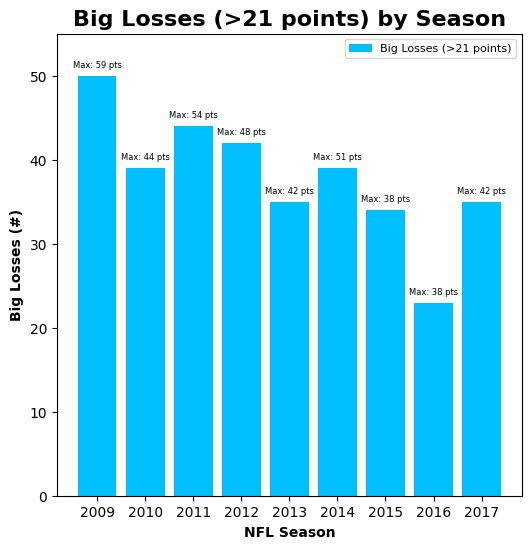

In [73]:
#Create groupings using last line in the game
final_scores = updated_nfl_plays.groupby(['Season', 'GameID']).last()
big_loss = final_scores[final_scores['AbsScoreDiff'] > 21].groupby('Season').size()
max_diff = final_scores.groupby('Season')['AbsScoreDiff'].agg(['mean', 'max'])


#Create a bar plot: Score Differentials and Number of Big Losses (>21pts)
plt.figure(figsize=(6, 6))
plt.bar(big_loss.index, big_loss, color='deepskyblue', label='Big Losses (>21 points)', width=0.8)

#Add text annotations to show worse loss differential
for season in max_diff.index:
    max_value = max_diff.at[season, 'max']
    plt.text(season, big_loss.get(season, 0) + 1, f'Max: {int(max_value)} pts', ha='center', fontsize=6)

#Setting labels
plt.title('Big Losses (>21 points) by Season', fontweight = 'bold',fontsize=16)
plt.legend(loc='upper right',fontsize=8)
plt.ylim(top= 55)
plt.xlabel('NFL Season', fontweight='bold')
plt.ylabel('Big Losses (#)',fontweight = 'bold')
plt.xticks(max_diff.index)
plt.show()

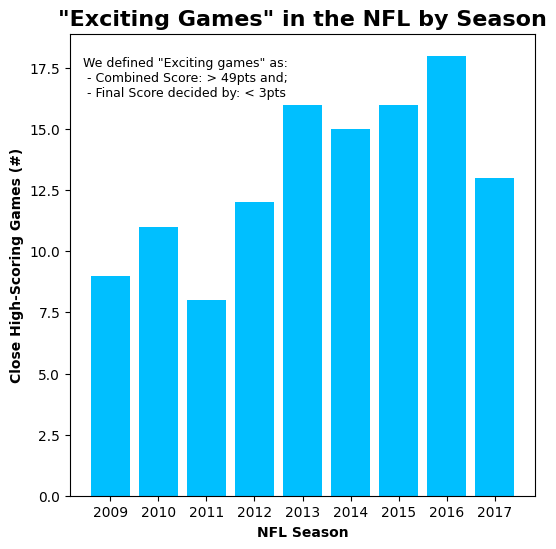

In [70]:
#Filter the dataset to include games where the total combined score is more than 49 and the final score differential is less than 3
close_high_scoring_games = final_scores[(final_scores['PosTeamScore'] + final_scores['DefTeamScore'] > 49) & (final_scores['AbsScoreDiff'] < 3)]

#Count the number of games per season
close_high_scoring_game_counts = close_high_scoring_games.groupby('Season').size()

#Create a bar plot
plt.figure(figsize=(6, 6))
plt.bar(close_high_scoring_game_counts.index, close_high_scoring_game_counts, color='deepskyblue')

#Setting labels
plt.title('"Exciting Games" in the NFL by Season',fontweight='bold',fontsize=16)
plt.xlabel('NFL Season',fontweight='bold')
plt.ylabel('Close High-Scoring Games (#)',fontweight='bold')
plt.xticks(close_high_scoring_game_counts.index)
callout = ' We defined "Exciting games" as:\n  - Combined Score: > 49pts and; \n  - Final Score decided by: < 3pts'
plt.text(0.02, 0.95, callout, transform=plt.gca().transAxes, fontsize=9, verticalalignment='top')
plt.grid(False)

plt.show()

In [9]:
#Calculate total games
total_games = updated_nfl_plays['GameID'].nunique()

#Calculate total plays
total_plays = len(updated_nfl_plays)

#Calculate total yards gained
total_yards_gained = filtered_plays_for_yards['Yards.Gained'].sum()

#Calculate total touchdowns scored (assuming 'Touchdown' is 1 for a touchdown)
total_touchdowns = updated_nfl_plays['Touchdown'].sum()

print(f"Total Games: {total_games}")
print(f"Total Touchdowns Scored: {total_touchdowns}")
print(f"Total Plays: {total_plays}") #includes timeouts, penalties, etc.
print(f"Total Yards Gained: {total_yards_gained}")


Total Games: 2304
Total Touchdowns Scored: 11851
Total Plays: 407688
Total Yards Gained: 1907906


# Section 3: Impact of General Factors on Offense

Now that we have an understanding of these dynamics we want to spend some more time digging into what these offenses look like and how different teams are executing their strategies.

One of the most critical aspects of American football is the First Down. Understanding the distribution of what plays are typically executed and where can provide valuable insights to any coach on both the offensive and defensive sides of the ball.

When exploring the influence of field position on offensive strategies, we created a detailed chart that categorizes play types based on the distance remaining for a first down separated by the specific down. This chart offers insightful data on how teams adapt their play-calling in varying field positions:

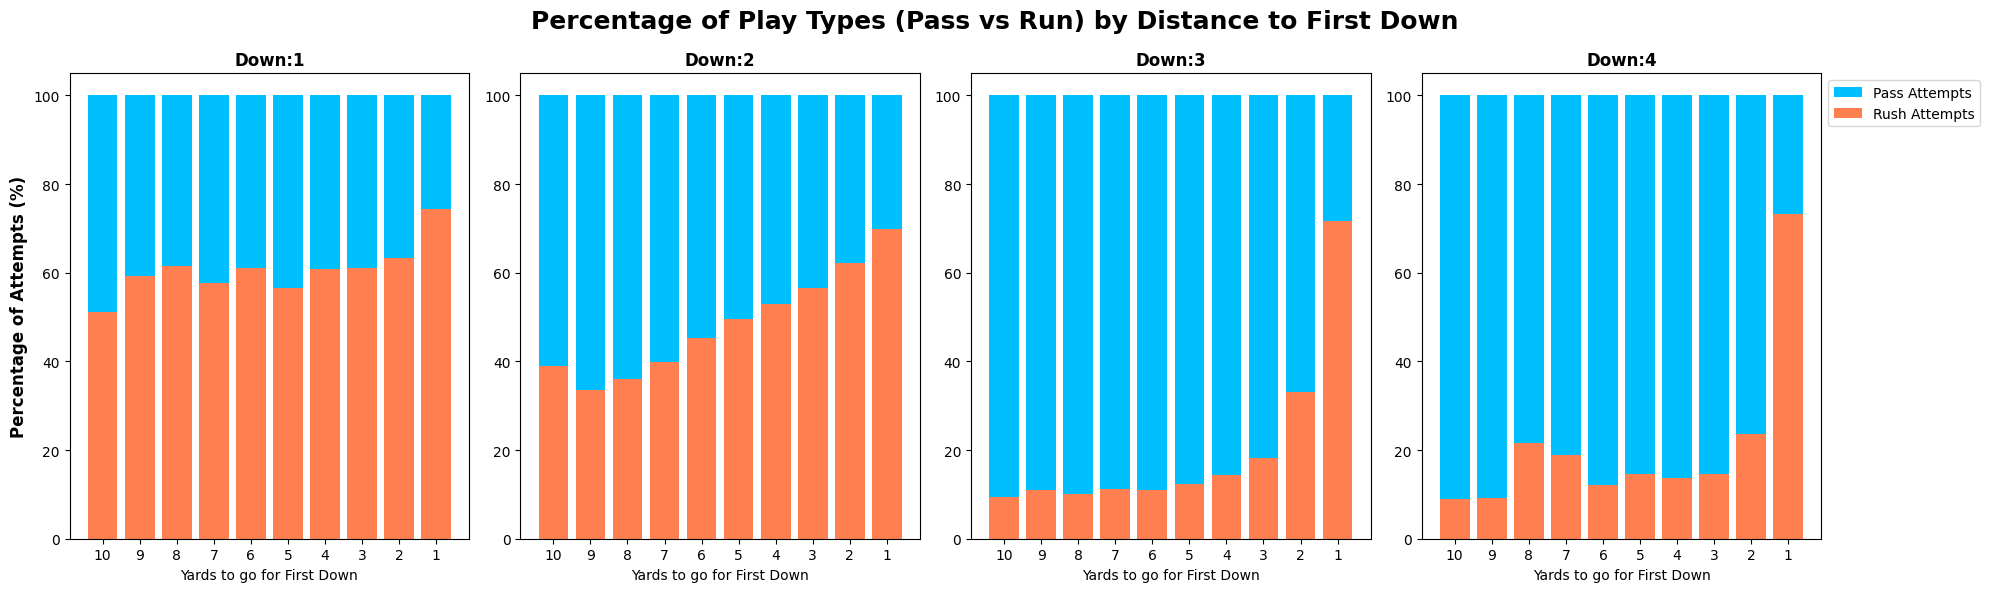

In [85]:
downs = [1, 2, 3, 4]

#Create subplots for each down
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))

#Loop through each down and create a stacked bar chart
for i, down in enumerate(downs):
    # Filter the data for the current down
    filtered_nfl_plays = updated_nfl_plays[(updated_nfl_plays['down'] == down) & (updated_nfl_plays['ydstogo'] <= 10) & (updated_nfl_plays['ydstogo'] > 0)]
    grouped_by_distance_FirstDown = filtered_nfl_plays.groupby(['ydstogo']).agg({
        'RushAttempt': 'sum',
        'PassAttempt': 'sum',
    }).reset_index()

    #Calculate the total attempts for each yard
    grouped_by_distance_FirstDown['TotalAttempts'] = (grouped_by_distance_FirstDown['RushAttempt'] + grouped_by_distance_FirstDown['PassAttempt'])
    
    #Calculate the percentage of each type of Play Type (Rush and Pass)
    grouped_by_distance_FirstDown['RushAttemptPct'] = ((grouped_by_distance_FirstDown['RushAttempt'] / grouped_by_distance_FirstDown['TotalAttempts']) * 100)
    grouped_by_distance_FirstDown['PassAttemptPct'] = ((grouped_by_distance_FirstDown['PassAttempt'] / grouped_by_distance_FirstDown['TotalAttempts']) * 100)

    #Plot stacked bar chart on the current subplot
    bars_pass = axes[i].bar(grouped_by_distance_FirstDown['ydstogo'], grouped_by_distance_FirstDown['PassAttemptPct'], bottom=grouped_by_distance_FirstDown['RushAttemptPct'], label='Pass Attempts', color='deepskyblue')
    bars_rush = axes[i].bar(grouped_by_distance_FirstDown['ydstogo'], grouped_by_distance_FirstDown['RushAttemptPct'], label='Rush Attempts', color='Coral')

    #Setting labels
    axes[i].set_title(f'Down:{down}',fontweight='bold')
    axes[i].set_xlabel('Yards to go for First Down')
    axes[i].set_xticks(grouped_by_distance_FirstDown['ydstogo'])
    axes[i].invert_xaxis()

#Setting labels and titles
plt.suptitle('Percentage of Play Types (Pass vs Run) by Distance to First Down',fontweight = 'bold',fontsize=18)
axes[0].set_ylabel('Percentage of Attempts (%)',fontweight='bold', fontsize = 12)
axes[3].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

We can quickly see a hand full of insights by Down:
- On First Down:  the data shows a balanced distribution between different play types, indicating a balanced strategy and defenses should play conservatively
- During Second Down: a notable shift in play selection occurs if lmore than five yards were gained on 1st down, with a higher inclination towards running plays
- On Third and Fourth Downs: the trend strongly favors passing plays, except in scenarios where only one yard is needed for a first down 

All of these insights can inform an offensive and defensive coach’s strategy. We can also break this down even further by what direction the play is actually executed:


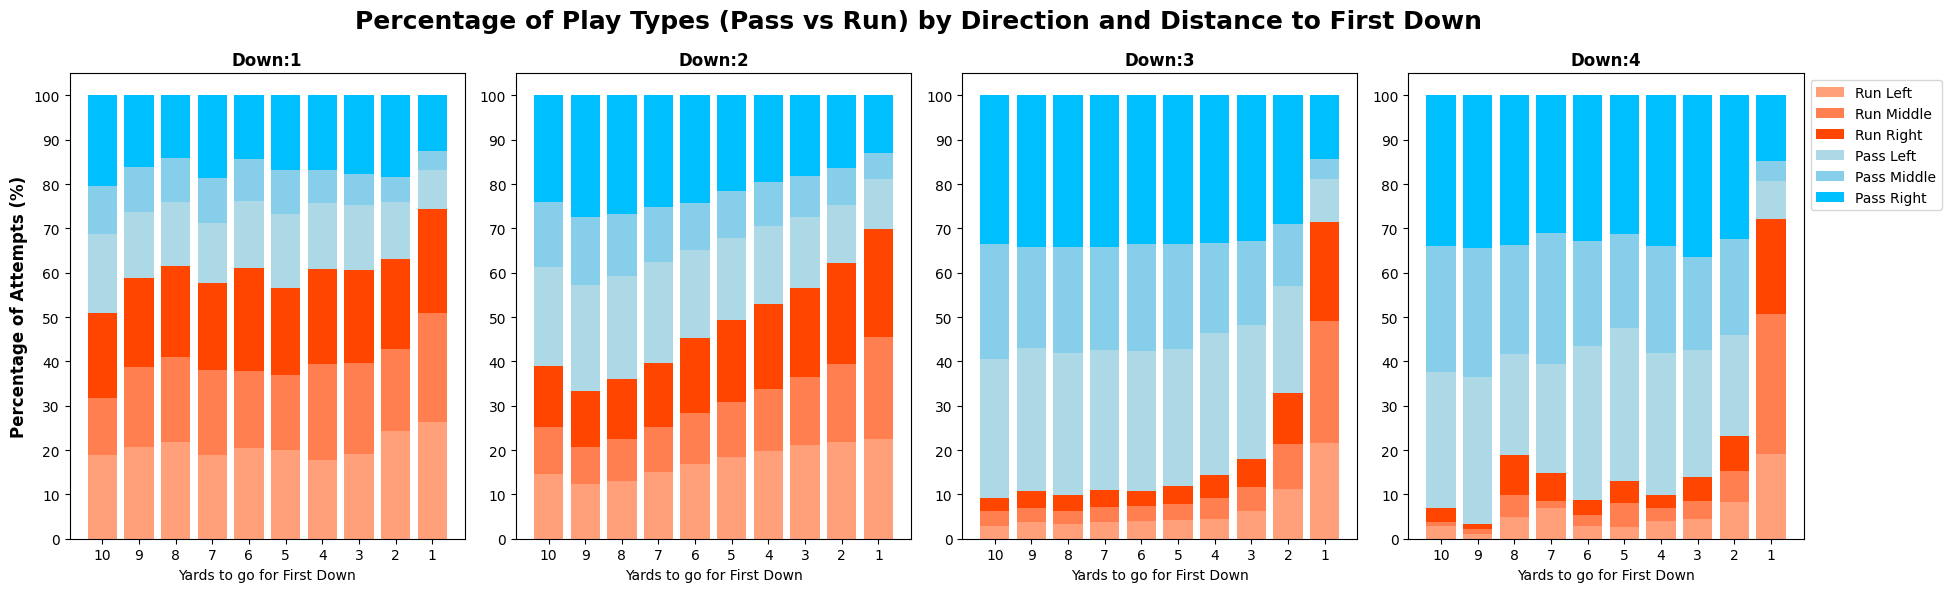

In [135]:
#Create subplots for each down
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 6))
colors = ['LightSalmon', 'Coral', 'OrangeRed', 'lightblue', 'skyblue', 'deepskyblue']
labels = ['Run Left', 'Run Middle', 'Run Right', 'Pass Left', 'Pass Middle', 'Pass Right']

#Loop through each down and create a stacked bar chart
for i, down in enumerate(downs):
    # Filter the data for the current Down
    filtered_nfl_plays = updated_nfl_plays[(updated_nfl_plays['down'] == down) & (updated_nfl_plays['ydstogo'] <= 10) & (updated_nfl_plays['ydstogo'] > 0)]

    #Group, aggregate and sum data by yards to go
    grouped_by_distance_FirstDown = filtered_nfl_plays.groupby('ydstogo').agg({
        'RunLocation_left': 'sum',
        'RunLocation_middle': 'sum',
        'RunLocation_right': 'sum',
        'PassLocation_left': 'sum',
        'PassLocation_middle': 'sum',
        'PassLocation_right': 'sum'
    }).reset_index()

    #Convert to percentage
    total_attempts = grouped_by_distance_FirstDown[['RunLocation_left', 'RunLocation_middle', 'RunLocation_right','PassLocation_left', 'PassLocation_middle', 'PassLocation_right']].sum(axis=1)
    for column in grouped_by_distance_FirstDown.columns[1:]:grouped_by_distance_FirstDown[column] = (grouped_by_distance_FirstDown[column] / total_attempts) * 100

    #Create a stacked bar chart for current Down
    bottom = np.zeros(len(grouped_by_distance_FirstDown))

    #Iterates over the colors and lables (Reference code: https://realpython.com/python-zip-function/)
    for col, color, label in zip(grouped_by_distance_FirstDown.columns[1:], colors, labels):
        axes[i].bar(grouped_by_distance_FirstDown['ydstogo'], grouped_by_distance_FirstDown[col], bottom=bottom, color=color, label=label)
        bottom += grouped_by_distance_FirstDown[col]

    #Add labels and title to the current subplot
    axes[i].set_title(f'Down:{down}',fontweight='bold')
    axes[i].set_xlabel('Yards to go for First Down')
    axes[i].set_xticks(grouped_by_distance_FirstDown['ydstogo'])
    axes[i].invert_xaxis()
    axes[i].set_yticks(range(0, 101, 10))

#Setting labels and titles
plt.suptitle('Percentage of Play Types (Pass vs Run) by Direction and Distance to First Down',fontweight = 'bold', fontsize = 18)
plt.tight_layout()
axes[0].set_ylabel('Percentage of Attempts (%)',fontsize = 12,fontweight = 'bold')
axes[3].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In addition to the insights we already highlighted, several more patterns emerge by play type:
- Pass Plays: During first and second downs, there's a significant tendency to steer clear of passes to the middle, with teams generally opting for passes to the left or right side of the field. On third and fourth downs, though there's a slight increase in passes directed towards the middle. Finally, it appears the closer the quarter back is to the first down the more likely they are to throw a right sided pass.
- Run Plays: On first down, the direction of running plays is balanced, showing no strong preference for any side. However, in later downs, the direction for running plays varies more, largely influenced by the distance remaining to a first down. Left or right sided runs are preferred until only a yard remains.

These are all helpful insights as play moves down the field, but lets do a double click into the redzone and see what happens to play distribution when the team is only ten yards away from the endzone.


In [111]:
#Create Redzone Group for analysis (<=10 yards)
filtered_nfl_plays_redzone = updated_nfl_plays[updated_nfl_plays['yrdline100'] <= 10]
grouped_by_distance_redzone = filtered_nfl_plays_redzone.groupby(['yrdline100']).agg({
    'RushAttempt': 'sum',
    'PassAttempt': 'sum',
    'Touchdown': 'sum',
    'RunLocation_left': 'sum',
    'RunLocation_middle': 'sum',
    'RunLocation_right': 'sum',
    'PassLocation_left': 'sum',
    'PassLocation_middle': 'sum',
    'PassLocation_right': 'sum'
}).reset_index()

grouped_by_distance_redzone.head()

,yrdline100,RushAttempt,PassAttempt,Touchdown,RunLocation_left,RunLocation_middle,RunLocation_right,PassLocation_left,PassLocation_middle,PassLocation_right
0,1.0,2243,926,1662,722,791,678,295,142,476
1,2.0,1047,1282,746,364,335,323,302,158,396
2,3.0,824,883,652,258,284,271,310,195,374
3,4.0,776,986,568,235,270,256,341,221,414
4,5.0,860,1112,578,256,308,287,368,315,429


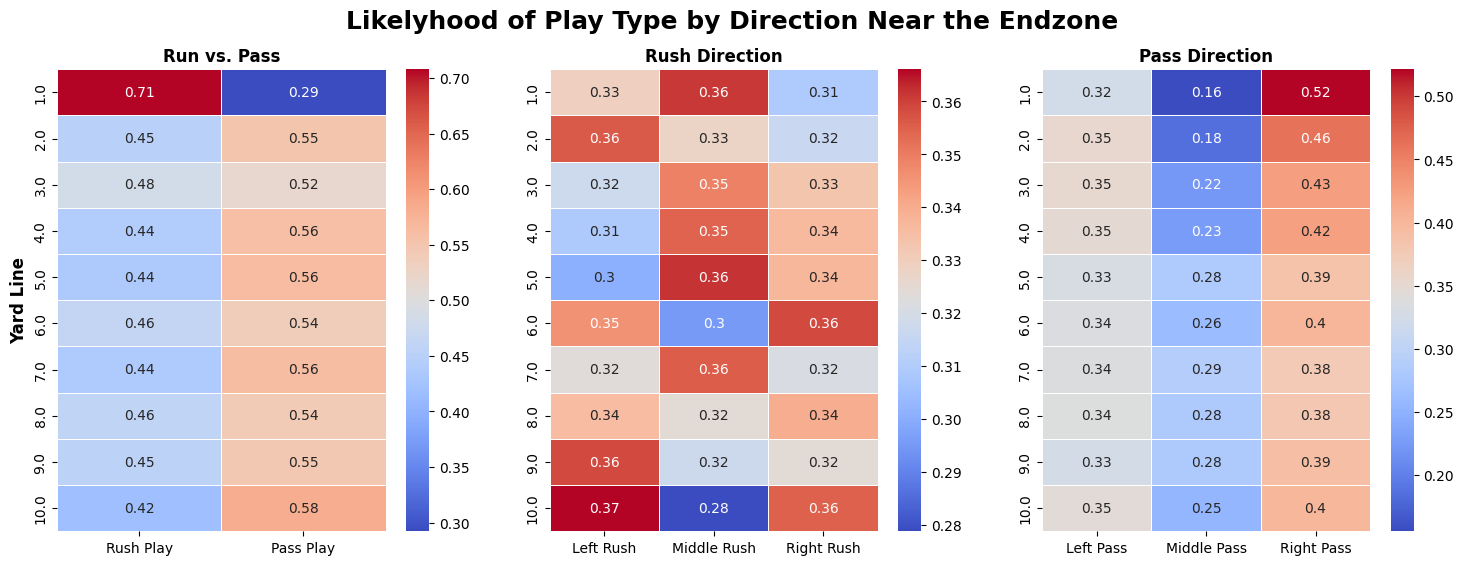

In [124]:
#Calculate the total plays
grouped_by_distance_redzone['TotalPlays'] = grouped_by_distance_redzone['RushAttempt'] + grouped_by_distance_redzone['PassAttempt']

#Calculate the percent of each play type
grouped_by_distance_redzone['RushAttemptProportion'] = grouped_by_distance_redzone['RushAttempt'] / grouped_by_distance_redzone['TotalPlays']
grouped_by_distance_redzone['PassAttemptProportion'] = grouped_by_distance_redzone['PassAttempt'] / grouped_by_distance_redzone['TotalPlays']

#Prepare the data for the Pass vs Rush heatmap
heatmap_data = grouped_by_distance_redzone.set_index('yrdline100')[['RushAttemptProportion', 'PassAttemptProportion']]
heatmap_data.rename(columns={'RushAttemptProportion': 'Rush Play', 'PassAttemptProportion': 'Pass Play'}, inplace=True)

#Calculating the total number of designed rush and pass attempts by direction
grouped_by_distance_redzone['TotalRushAttempts'] = grouped_by_distance_redzone[['RunLocation_left', 'RunLocation_middle', 'RunLocation_right']].sum(axis=1)
grouped_by_distance_redzone['TotalPassAttempts'] = grouped_by_distance_redzone[['PassLocation_left', 'PassLocation_middle', 'PassLocation_right']].sum(axis=1)

#Calculating the percent of each rush and pass direction
for direction in ['left', 'middle', 'right']:
    grouped_by_distance_redzone[f'Rush_{direction}_Prop'] = grouped_by_distance_redzone[f'RunLocation_{direction}'] / grouped_by_distance_redzone['TotalRushAttempts']
    grouped_by_distance_redzone[f'Pass_{direction}_Prop'] = grouped_by_distance_redzone[f'PassLocation_{direction}'] / grouped_by_distance_redzone['TotalPassAttempts']

#Preparing data for Rush direction proportions heatmap
rush_props = grouped_by_distance_redzone.set_index('yrdline100')[['Rush_left_Prop', 'Rush_middle_Prop', 'Rush_right_Prop']]
rush_props.rename(columns={'Rush_left_Prop': 'Left Rush', 'Rush_middle_Prop': 'Middle Rush', 'Rush_right_Prop': 'Right Rush'}, inplace=True)

#Preparing data for Pass direction proportions heatmap
pass_props = grouped_by_distance_redzone.set_index('yrdline100')[['Pass_left_Prop', 'Pass_middle_Prop', 'Pass_right_Prop']]
pass_props.rename(columns={'Pass_left_Prop': 'Left Pass', 'Pass_middle_Prop': 'Middle Pass', 'Pass_right_Prop': 'Right Pass'}, inplace=True)

#Create figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
fig.subplots_adjust(wspace=0.2)

#Chart 1: Heatmap for Play Type (Pass vs Rush) Likelihood in endzone
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=.5, ax=ax1)
ax1.set_title('Run vs. Pass', fontweight = 'bold')
ax1.set_ylabel('Yard Line', fontweight = 'bold',fontsize=12)

#Chart 2: Heatmap for Rush Direction near endzone
sns.heatmap(rush_props, annot=True, cmap='coolwarm', linewidths=.5, ax=ax2)
ax2.set_title('Rush Direction', fontweight = 'bold')
ax2.set_ylabel(None)

#Chart 3: Heatmap for Pass Direction near endzone
sns.heatmap(pass_props, annot=True, cmap='coolwarm', linewidths=.5, ax=ax3)
ax3.set_title('Pass Direction', fontweight = 'bold')
ax3.set_ylabel(None)


#Setting labels and titles
plt.suptitle('Likelyhood of Play Type by Direction Near the Endzone',fontweight = 'bold', fontsize = 18)
plt.show()

When we look at this chart we can see that passing plays dominate near the end zone until the 1-yard line, where preferences shift. In the red zone, right-sided passes are favored, while middle passes are rare.

Now that we have this understanding lets take a closer look at what areas of the field might be high risk areas for turnovers (fumbles and interceptions).

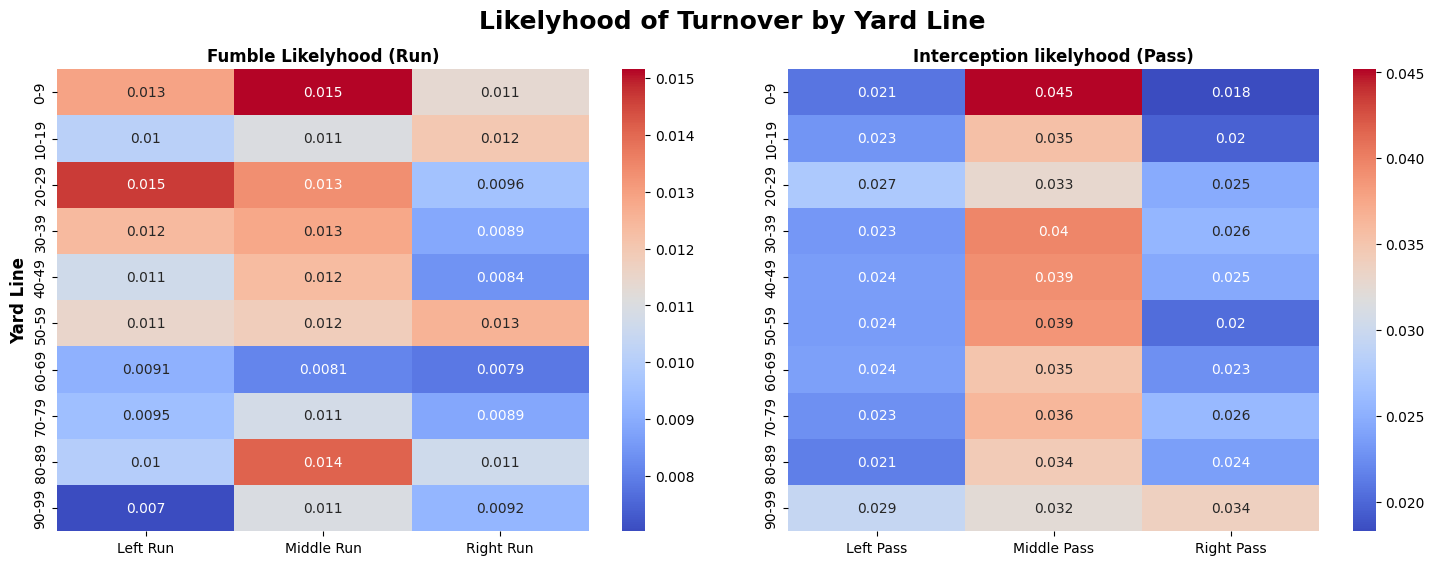

In [136]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
fig.subplots_adjust(wspace=0.1)

#Chart 1: Preparing the data - Group by the new yardline range and run location, and calculate fumble rate
fumble_rate = updated_nfl_plays.groupby(['yrdline_range', 'RunLocation']).agg({'Fumble': 'mean'}).reset_index()
heatmap_fumble = fumble_rate.pivot(index='yrdline_range', columns='RunLocation', values='Fumble')

#Chart 1: Heatmap of Interception Proportion by Yardline and Pass Location
sns.heatmap(heatmap_fumble, annot=True, cmap="coolwarm", ax=ax1)
ax1.set_xticklabels(['Left Run', 'Middle Run', 'Right Run'])
ax1.set_title('Fumble Likelyhood (Run)', fontsize=12,fontweight = 'bold')
ax1.set_ylabel('Yard Line',fontweight='bold', fontsize=12)
ax1.set_xlabel(None)

#Chart 2: Preparing the data - Group by the new yardline range and pass location, and calculate interception rate
interception_rate = updated_nfl_plays.groupby(['yrdline_range', 'PassLocation']).agg({'InterceptionThrown': 'mean'}).reset_index()
heatmap_interception = interception_rate.pivot(index='yrdline_range', columns='PassLocation', values='InterceptionThrown')

#Chart 2: Heatmap of Interception Proportion by Yardline and Pass Location
sns.heatmap(heatmap_interception, annot=True, cmap="coolwarm", ax=ax2)
ax2.set_xticklabels(['Left Pass', 'Middle Pass', 'Right Pass'])
ax2.set_title('Interception likelyhood (Pass)', fontsize=12,fontweight = 'bold')
ax2.set_ylabel(None)
ax2.set_xlabel(None)

#Setting labels and titles
plt.suptitle('Likelyhood of Turnover by Yard Line',fontweight = 'bold',fontsize = 18)
plt.show()

According to the data running backs need to be extra cautious protecting the ball across mid field and running on the left side or middle. Quarterbacks, however, should be extra cautious about throwing the ball across the middle. One interesting link from the previous chart is we see the lowest interception rate is the right pass within the goal line which was also the highest play type from our heatmap on the previous slide so coaches are effectively playing to quarterbacks strengths near the endzone or at the very least playing to minimize mistakes.

# 3. Time Pressure Situation Impact Analysis

The final general lens we want to understand is what is the impact of of time pressure on critical errors fumbles, interceptions, and penalties:

In [125]:
#Create turnover group for TimeCategory
turnover_summary = updated_nfl_plays.groupby(['qtr', 'QuarterTimeCategory'])['TotalTurnovers'].sum()
turnover_unstacked = turnover_summary.unstack()
turnover_summary

qtr  QuarterTimeCategory
1    End                     685
     Middle                  664
     Start                   667
2    End                    1234
     Middle                  757
     Start                   787
3    End                     778
     Middle                  739
     Start                   798
4    End                    1442
     Middle                  802
     Start                   884
5    End                       5
     Middle                   17
     Start                    38
Name: TotalTurnovers, dtype: int64

In [126]:
#Create turnover group for TimeCategory
penalty_summary = updated_nfl_plays.groupby(['qtr', 'QuarterTimeCategory'])['PenaltyOccurred'].sum()
penalty_unstacked = penalty_summary.unstack()
penalty_summary

qtr  QuarterTimeCategory
1    End                    2265
     Middle                 2132
     Start                  1913
2    End                    3467
     Middle                 2381
     Start                  2578
3    End                    2375
     Middle                 2344
     Start                  2245
4    End                    2845
     Middle                 2354
     Start                  2422
5    End                      33
     Middle                   50
     Start                    95
Name: PenaltyOccurred, dtype: int64

In [127]:
# Create a group for TimeCategory and touchdowns
touchdowns_summary = updated_nfl_plays.groupby(['qtr', 'QuarterTimeCategory'])['Touchdown'].sum()
touchdowns_unstacked = touchdowns_summary.unstack()
touchdowns_summary

qtr  QuarterTimeCategory
1    End                     895
     Middle                  865
     Start                   588
2    End                    1587
     Middle                  877
     Start                  1017
3    End                     915
     Middle                  996
     Start                   655
4    End                    1370
     Middle                 1044
     Start                  1005
5    End                       6
     Middle                   15
     Start                    16
Name: Touchdown, dtype: int64

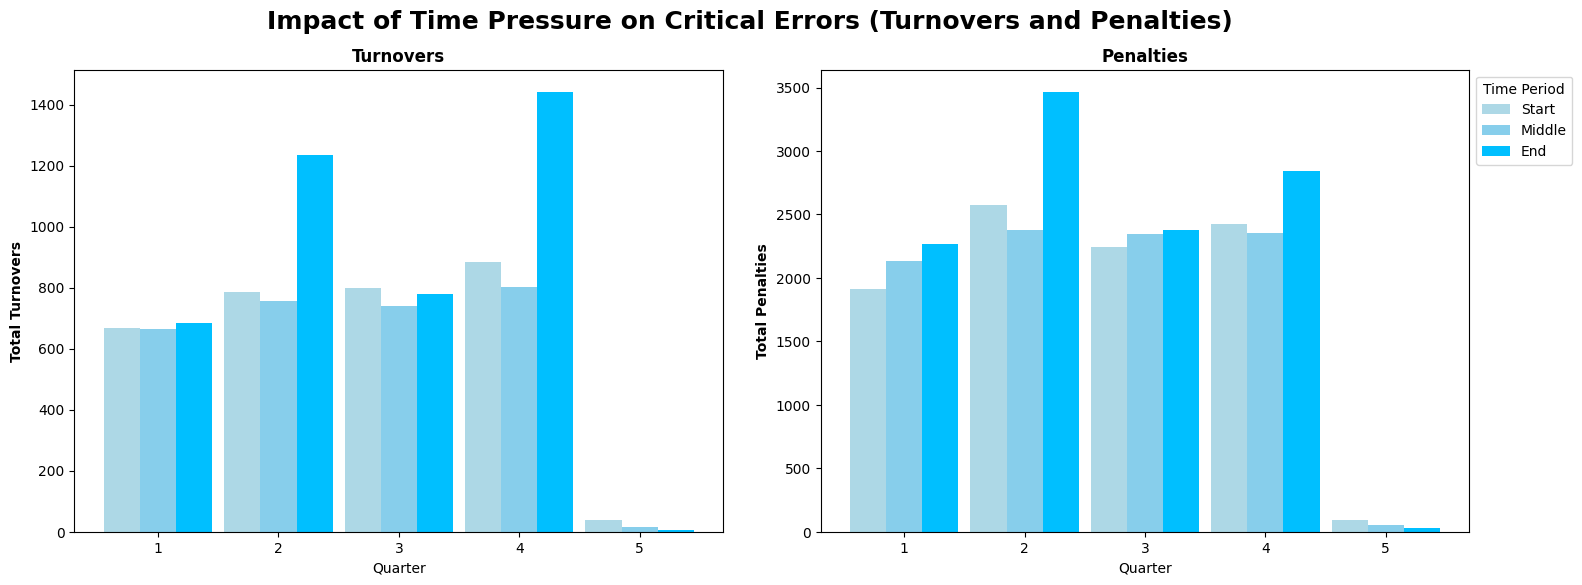

In [129]:
#Set up the bar width and positions
bar_width = 0.3
quarters = np.arange(len(turnover_unstacked))

#Calculate positions for each group
start_positions = quarters - bar_width
middle_positions = quarters
last_positions = quarters + bar_width

#Set up figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
fig.subplots_adjust(wspace=0.15, hspace=0.5)

#Chart 1: Turnovers by Time Period
ax1.bar(start_positions, turnover_unstacked['Start'], width=bar_width, label='Start',color = 'lightblue')
ax1.bar(middle_positions, turnover_unstacked['Middle'], width=bar_width, label='Middle',color = 'skyblue')
ax1.bar(last_positions, turnover_unstacked['End'], width=bar_width, label='End', color='deepskyblue')

#Chart 1: Setting Labels
ax1.set_xlabel('Quarter')
ax1.set_ylabel('Total Turnovers',fontweight = 'bold')
ax1.set_title('Turnovers',fontweight='bold')
ax1.set_xticks(quarters)
ax1.set_xticklabels(turnover_unstacked.index)

#Chart 2: Penalties by Time Period
ax2.bar(start_positions, penalty_unstacked['Start'], width=bar_width, label='Start',color = 'lightblue')
ax2.bar(middle_positions, penalty_unstacked['Middle'], width=bar_width, label='Middle',color = 'skyblue')
ax2.bar(last_positions, penalty_unstacked['End'], width=bar_width, label='End', color='deepskyblue')

#Chart 2: Setting Labels
ax2.set_xlabel('Quarter')
ax2.set_ylabel('Total Penalties',fontweight ='bold')
ax2.set_title('Penalties',fontweight = 'bold')
ax2.set_xticks(quarters)
ax2.set_xticklabels(penalty_unstacked.index)

#Show the plot
plt.suptitle('Impact of Time Pressure on Critical Errors (Turnovers and Penalties)',fontweight = 'bold',fontsize = 18)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1),title='Time Period')
plt.show()

We see that time pressure increases turnovers in the late 2nd and 4th quarters and drives up 2nd-quarter penalties. This is a good indication that coaches should ensure their teams are extra discipline going into the end of the first half.